## Satellite Images Semantic Segmentation

### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from zipfile import ZipFile 
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

### Preparing Dataset

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

100% 246M/247M [00:12<00:00, 22.0MB/s]
100% 247M/247M [00:12<00:00, 20.2MB/s]


In [5]:
!unzip satellite-images-of-water-bodies.zip


Archive:  satellite-images-of-water-bodies.zip
replace Water Bodies Dataset/Images/water_body_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
images = "/content/Water Bodies Dataset/Images"
masks = "/content/Water Bodies Dataset/Masks"

In [7]:
files = []
paths = []

for dirname, _, filenames in os.walk(images):
  for filename in filenames:
    path = os.path.join(dirname, filename)
    paths.append(path)
    files.append(filename)

In [8]:
paths[0]

'/content/Water Bodies Dataset/Images/water_body_23.jpg'

In [9]:
mask_files = []
mask_paths = []

for dirname, _, filenames in os.walk(masks):
  for filename in filenames:
    path = os.path.join(dirname, filename)
    mask_paths.append(path)
    mask_files.append(filename)

In [10]:
mask_paths[0]

'/content/Water Bodies Dataset/Masks/water_body_23.jpg'

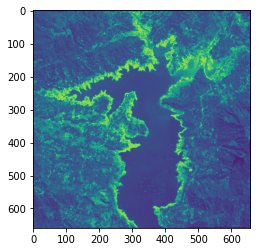

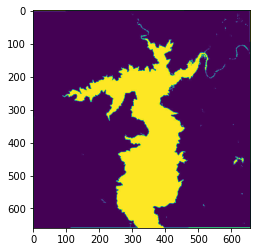

In [11]:
import cv2
sample = "/content/Water Bodies Dataset/Images/water_body_3.jpg"
mask_sample = "/content/Water Bodies Dataset/Masks/water_body_3.jpg"
img = cv2.imread(sample, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.show()

mask_img = cv2.imread(mask_sample, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask_img)
plt.show()

In [12]:
df = pd.DataFrame(columns = ['image', 'path', 'mask_paths', 'class'])
df['image'] = files
df['path'] = paths
df['mask_paths'] = mask_paths
df['class'] = 1

df.head(10)

image                                               path  \
0    water_body_23.jpg  /content/Water Bodies Dataset/Images/water_bod...   
1   water_body_844.jpg  /content/Water Bodies Dataset/Images/water_bod...   
2  water_body_1159.jpg  /content/Water Bodies Dataset/Images/water_bod...   
3   water_body_690.jpg  /content/Water Bodies Dataset/Images/water_bod...   
4  water_body_1759.jpg  /content/Water Bodies Dataset/Images/water_bod...   
5  water_body_1638.jpg  /content/Water Bodies Dataset/Images/water_bod...   
6  water_body_1811.jpg  /content/Water Bodies Dataset/Images/water_bod...   
7  water_body_7815.jpg  /content/Water Bodies Dataset/Images/water_bod...   
8  water_body_7045.jpg  /content/Water Bodies Dataset/Images/water_bod...   
9   water_body_166.jpg  /content/Water Bodies Dataset/Images/water_bod...   

                                          mask_paths  class  
0  /content/Water Bodies Dataset/Masks/water_body...      1  
1  /content/Water Bodies Dataset/Masks/water_body...      1  
2  /content/Water Bodies Dataset/Masks/water_body...      1  
3  /content/Water Bodies Dataset/Masks/water_body...      1  
4  /content/Water Bodies Dataset/Masks/water_body...      1  
5  /content/Water Bodies Dataset/Masks/water_body...      1  
6  /content/Water Bodies Dataset/Masks/water_body...      1  
7  /content/Water Bodies Dataset/Masks/water_body...      1  
8  /content/Water Bodies Dataset/Masks/water_body...      1  
9  /content/Water Bodies Dataset/Masks/water_body...      1

##Setting up the Train & Test data

In [13]:
df0 = df
n=len(df)
df=df0.iloc[0:(n//10)*3]
test_df=df0.iloc[(n//10)*3:(n//10)*4]

from car iamge segmentation using U-Net notebook @ https://www.kaggle.com/code/dikshabhati2002/image-segmentation-u-net:

In [14]:
img_size = [256,256]

def data_augmentation(car_img, mask_img):
    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return car_img, mask_img


def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path) 
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    return car_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mask_paths"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mask_paths"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [15]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)
test = create_dataset(test_df)

In [16]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [17]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

In [18]:
def display(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image','True Mask','Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

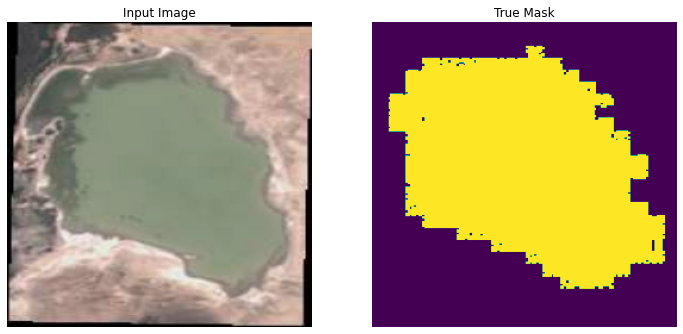

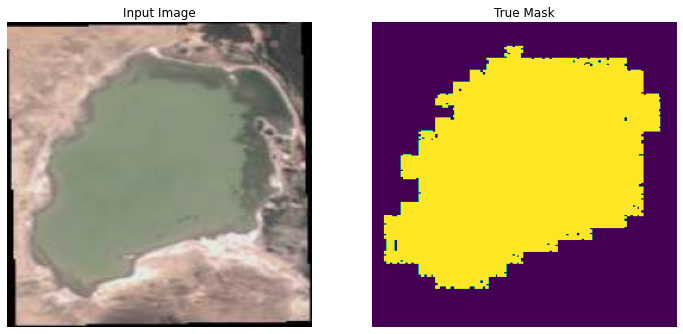

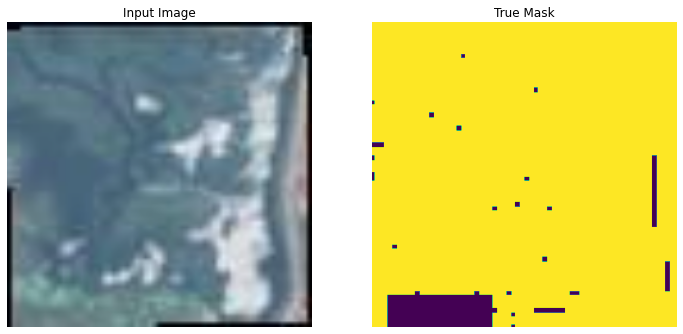

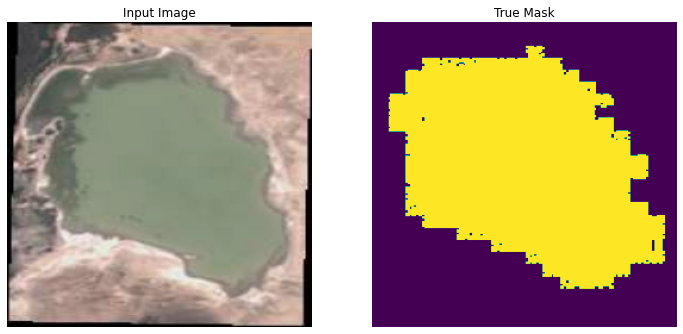

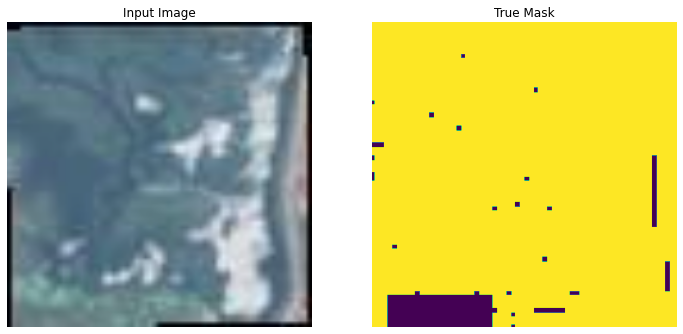

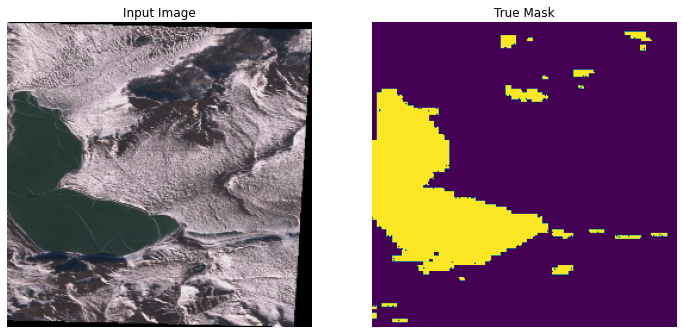

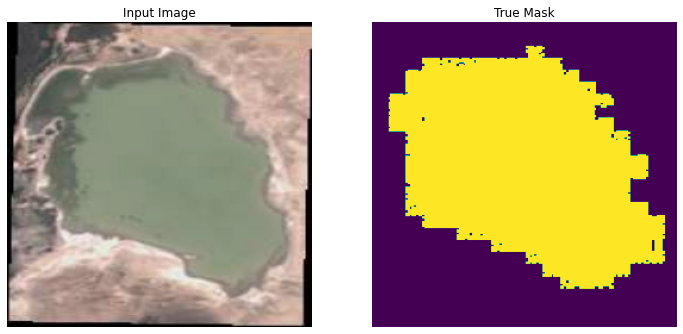

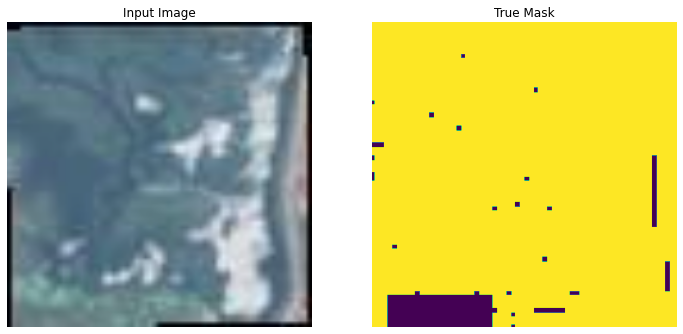

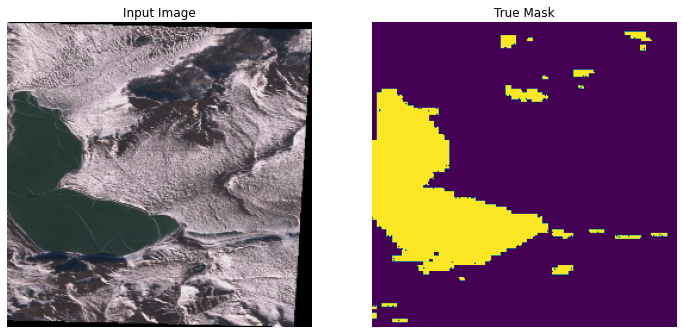

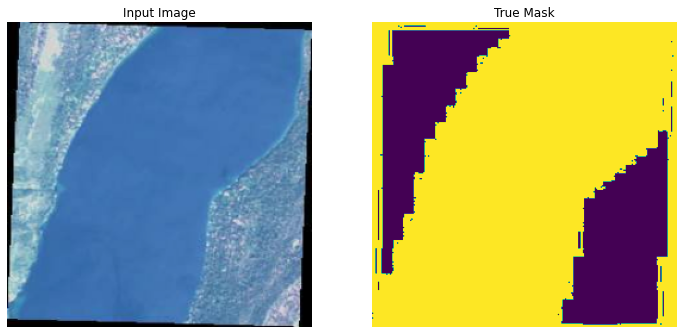

In [19]:
for i in range(5):
    for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])

### MobileNetV2 Model


In [20]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256,256,3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [21]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [22]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

###Training the model

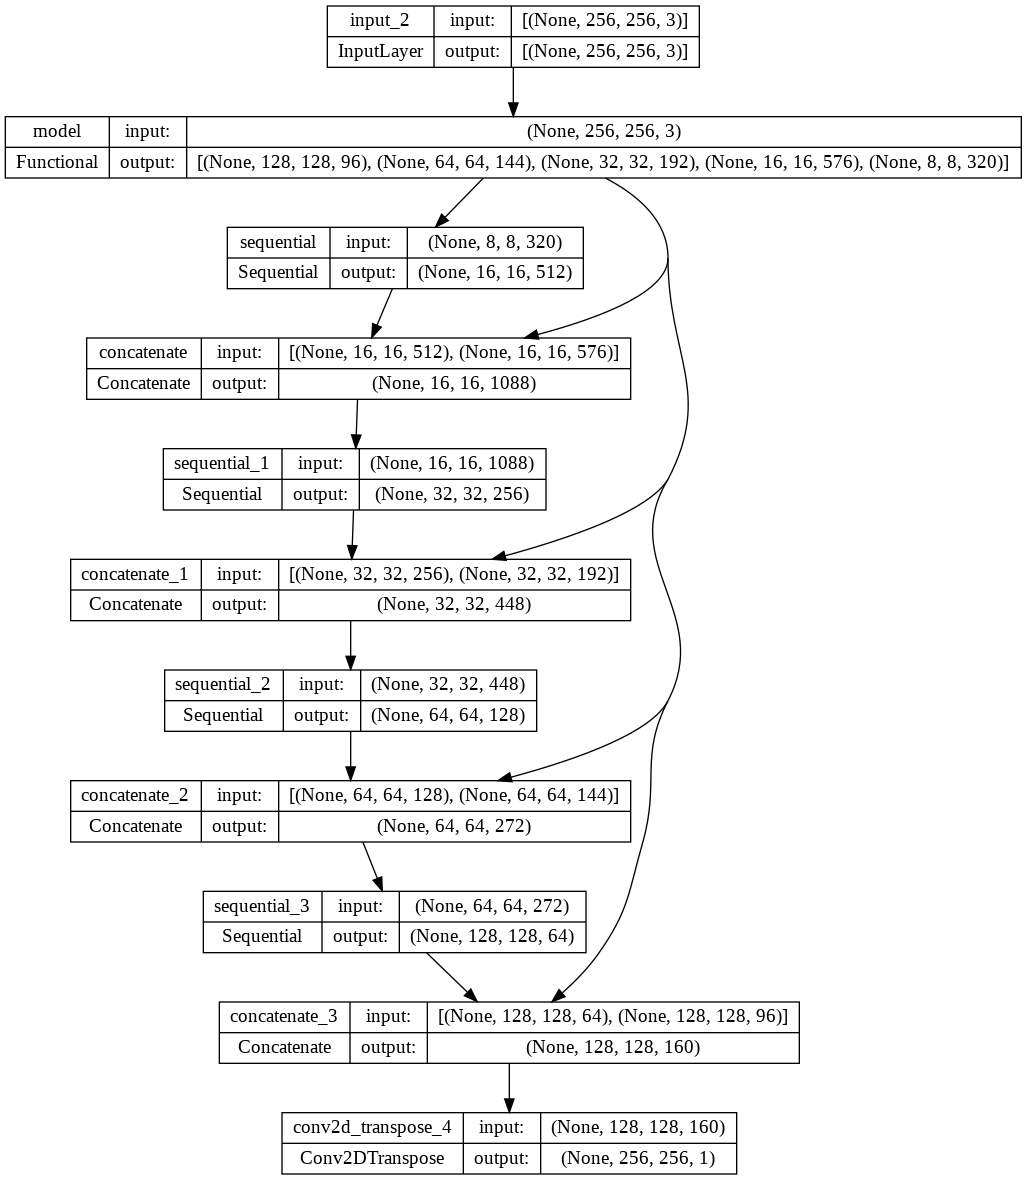

In [23]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
def visualize(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])

1/1 [==============================] - 8s 8s/step


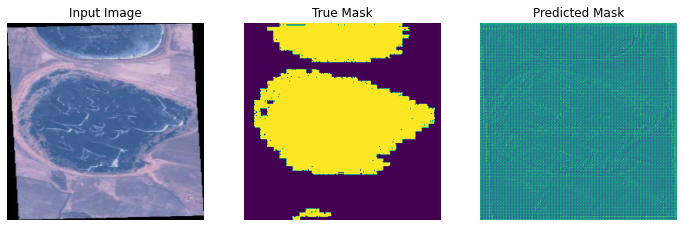

1/1 [==============================] - 0s 21ms/step


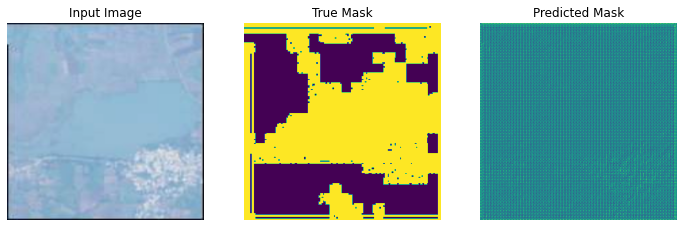

1/1 [==============================] - 0s 21ms/step


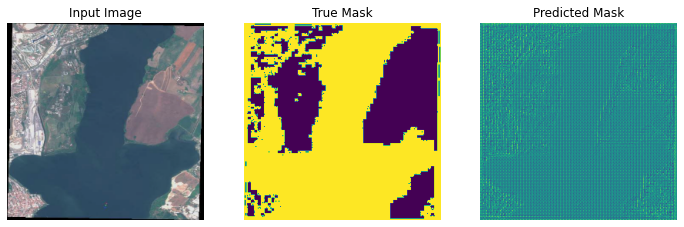

1/1 [==============================] - 0s 29ms/step


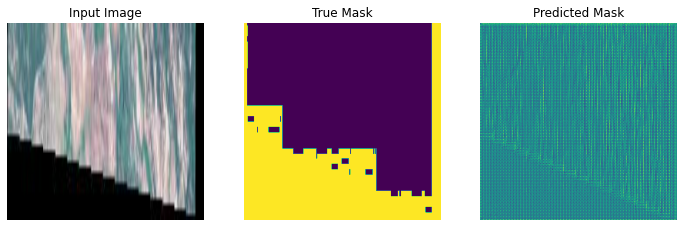

1/1 [==============================] - 0s 20ms/step


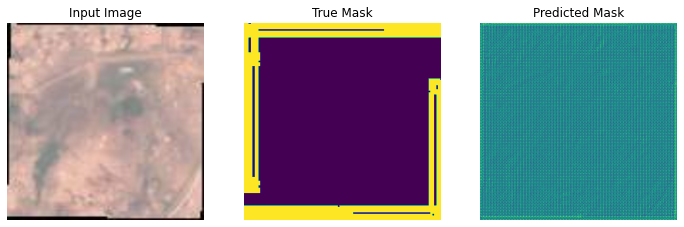

1/1 [==============================] - 0s 22ms/step


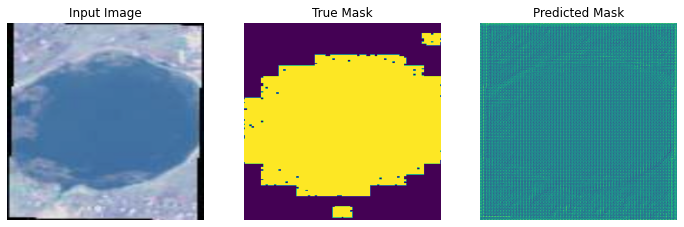

1/1 [==============================] - 0s 19ms/step


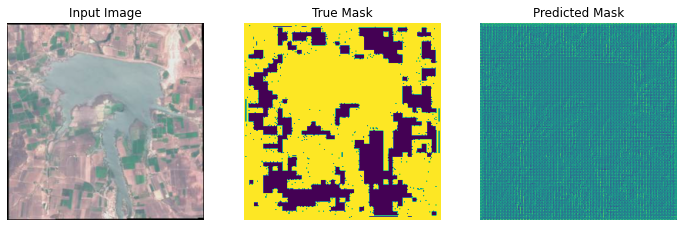

1/1 [==============================] - 0s 23ms/step


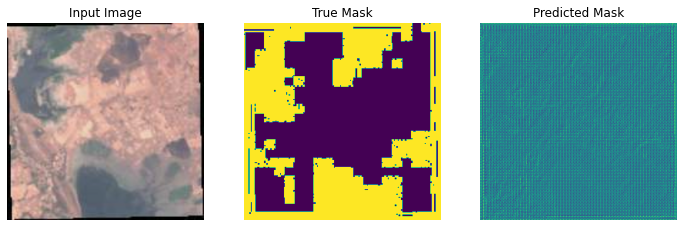

1/1 [==============================] - 0s 20ms/step


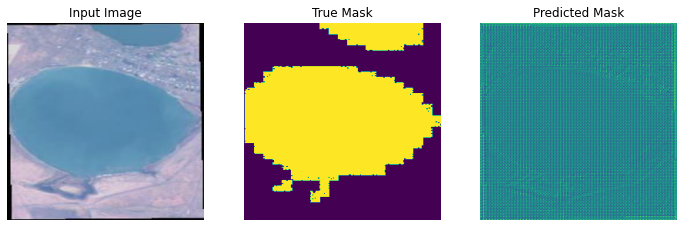

1/1 [==============================] - 0s 25ms/step


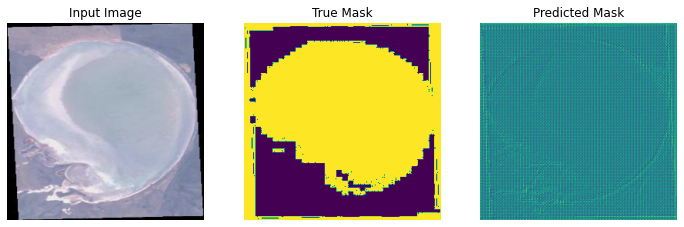

In [25]:
for i in range(5):
    for images, masks in train_dataset.take(i):
        for img, mask in zip(images, masks):
            sample_image = img
            sample_mask = mask
            show_predictions(sample_image, sample_mask)
            break


In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 128, 128, 9  1841984     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 192                                         

Epoch 1/40
39/39 [==============================] - 15s 243ms/step - loss: 0.3634 - dice_coef: 0.6366 - binary_accuracy: 0.6560 - val_loss: 0.3140 - val_dice_coef: 0.6853 - val_binary_accuracy: 0.7165
Epoch 2/40
1/1 [==============================] - 0s 21ms/step


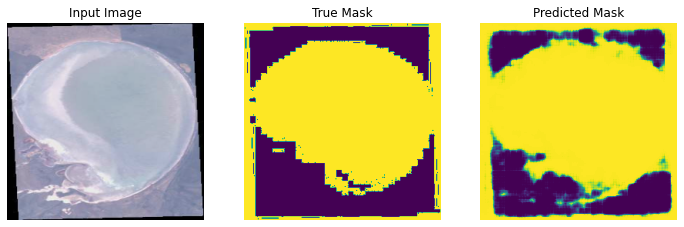

Epoch 3/40
39/39 [==============================] - 5s 133ms/step - loss: 0.2670 - dice_coef: 0.7329 - binary_accuracy: 0.7853 - val_loss: 0.2887 - val_dice_coef: 0.7074 - val_binary_accuracy: 0.7810
Epoch 4/40
39/39 [==============================] - 5s 138ms/step - loss: 0.2648 - dice_coef: 0.7352 - binary_accuracy: 0.7849 - val_loss: 0.2884 - val_dice_coef: 0.7080 - val_binary_accuracy: 0.7844
Epoch 5/40
1/1 [==============================] - 0s 19ms/step


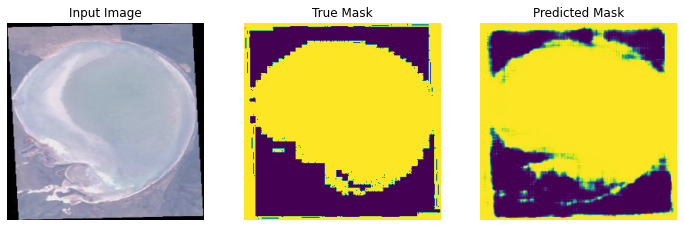

Epoch 6/40
39/39 [==============================] - 5s 138ms/step - loss: 0.2539 - dice_coef: 0.7461 - binary_accuracy: 0.7921 - val_loss: 0.2834 - val_dice_coef: 0.7138 - val_binary_accuracy: 0.7716
Epoch 7/40
39/39 [==============================] - 7s 176ms/step - loss: 0.2510 - dice_coef: 0.7490 - binary_accuracy: 0.7963 - val_loss: 0.2827 - val_dice_coef: 0.7140 - val_binary_accuracy: 0.7610
Epoch 8/40
1/1 [==============================] - 0s 22ms/step


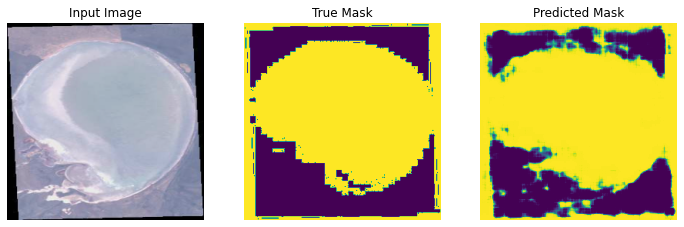

Epoch 9/40
39/39 [==============================] - 5s 139ms/step - loss: 0.2358 - dice_coef: 0.7643 - binary_accuracy: 0.8024 - val_loss: 0.2764 - val_dice_coef: 0.7202 - val_binary_accuracy: 0.7763
Epoch 10/40
39/39 [==============================] - 5s 140ms/step - loss: 0.2470 - dice_coef: 0.7529 - binary_accuracy: 0.8006 - val_loss: 0.2751 - val_dice_coef: 0.7210 - val_binary_accuracy: 0.7820
Epoch 11/40
1/1 [==============================] - 0s 20ms/step


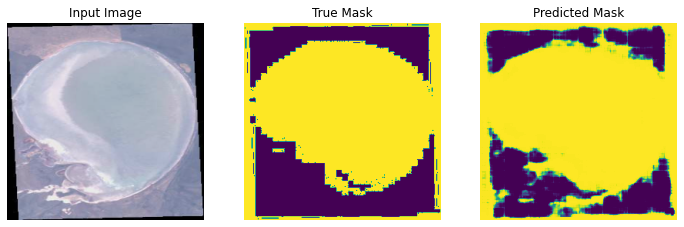

Epoch 12/40
39/39 [==============================] - 6s 142ms/step - loss: 0.2388 - dice_coef: 0.7612 - binary_accuracy: 0.8028 - val_loss: 0.2772 - val_dice_coef: 0.7186 - val_binary_accuracy: 0.7872
Epoch 13/40
39/39 [==============================] - 5s 142ms/step - loss: 0.2416 - dice_coef: 0.7584 - binary_accuracy: 0.8017 - val_loss: 0.2751 - val_dice_coef: 0.7212 - val_binary_accuracy: 0.7878
Epoch 14/40
39/39 [==============================] - 6s 145ms/step - loss: 0.2362 - dice_coef: 0.7638 - binary_accuracy: 0.8099 - val_loss: 0.2768 - val_dice_coef: 0.7199 - val_binary_accuracy: 0.7828


In [27]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 40
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])



In [29]:
model.save("model.h5")

1/1 [==============================] - 0s 112ms/step


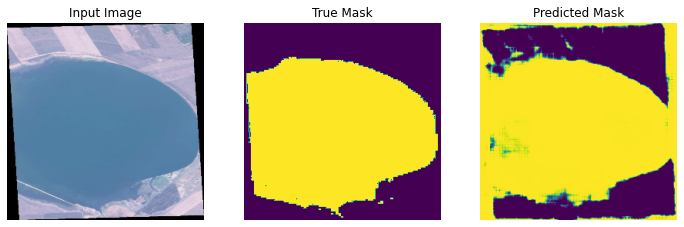

1/1 [==============================] - 0s 78ms/step


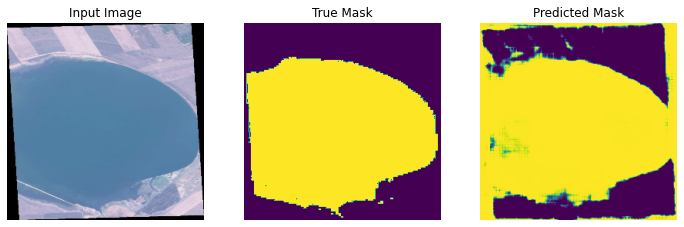

1/1 [==============================] - 0s 19ms/step


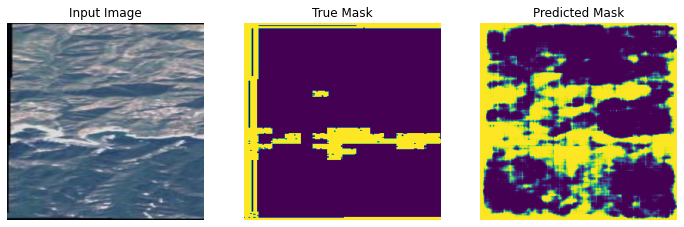

1/1 [==============================] - 0s 64ms/step


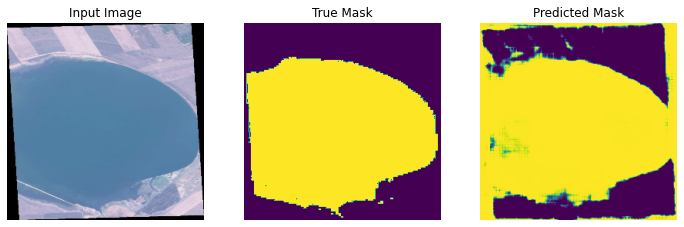

1/1 [==============================] - 0s 27ms/step


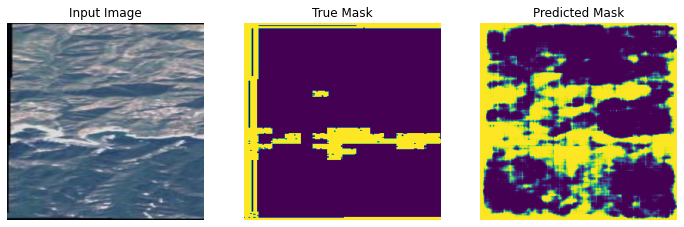

1/1 [==============================] - 0s 44ms/step


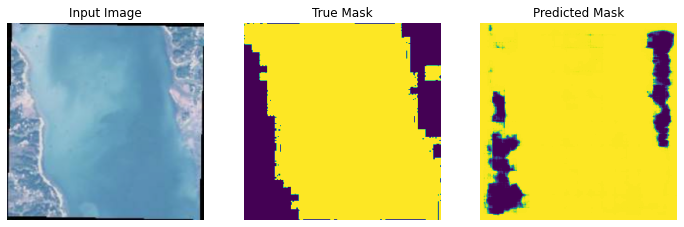

1/1 [==============================] - 0s 58ms/step


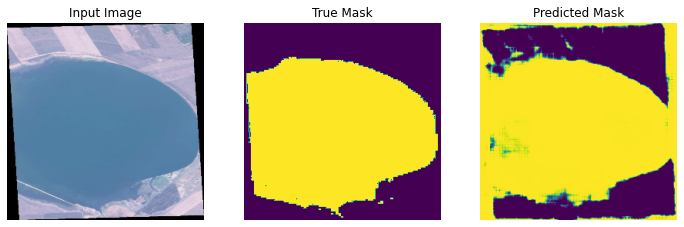

1/1 [==============================] - 0s 45ms/step


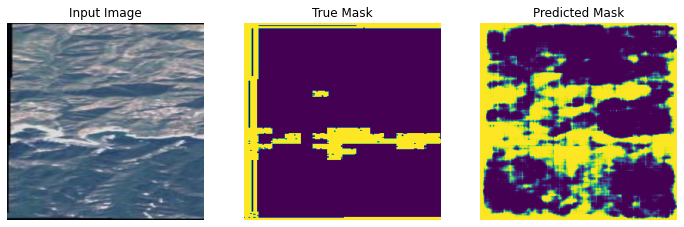

1/1 [==============================] - 0s 29ms/step


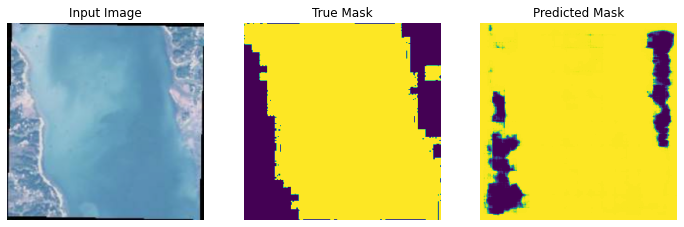

1/1 [==============================] - 0s 65ms/step


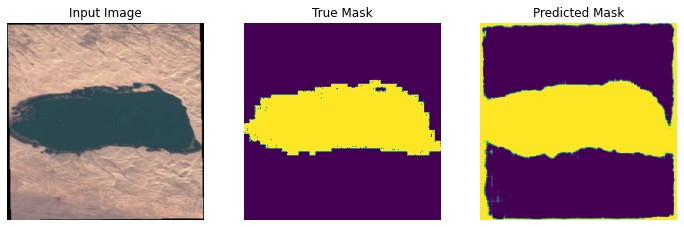

In [30]:
for i in range(5):
    for images, masks in test_dataset.take(i):
        for img, mask in zip(images, masks):
            tsample_image = img
            tsample_mask = mask
            show_predictions(tsample_image, tsample_mask)
            break